In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

C:\Users\Admin\AppData\Local\Temp\ipykernel_13296\2188477860.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


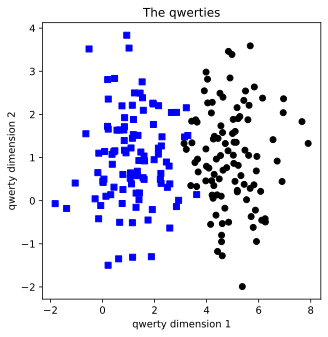

In [3]:
# create data

nPerClust = 100
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]

# generate data
a = [ A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [ B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

# concatenate into a matrix
data_np = np.hstack((a, b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize = (5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], "bs")
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], "ko")
plt.title("The qwerties")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [4]:
def createANNmodel(learningRate):

    # build the model
    ANNclassify = nn.Sequential(
        nn.Linear(2, 1), # input layer; 2 inputs, 1 output
        nn.ReLU(), # activation unit
        nn.Linear(1, 1), # output unit; 1 input, 1 output
        ## nn.Sigmoid() # final activation unit (here for conceptual reasons)
    )

    # loss function
    lossfun = nn.BCEWithLogitsLoss() # calculates sigmoid function as well
    
    # optimizer
    optimizer = torch.optim.SGD(ANNclassify.parameters(), lr = learningRate)

    # model output
    return ANNclassify, lossfun, optimizer

In [5]:
# function that trains the model

# train the model
numepochs = 1000

def trainTheModel(ANNmodel):

    # initialize the losses
    losses = torch.zeros(numepochs)

    # train the model
    for epochi in range(numepochs):
    
        # forward pass
        yHat = ANNmodel(data)
    
        # compute loss
        loss = lossfun(yHat, labels)
        losses[epochi] = loss
    
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # final forward pass
    predictions = ANNmodel(data)

    # compute the predictions and report accuracy
    # NOTE: shouldn'tit be predictions > .5?
    totalacc = 100*torch.mean(((predictions > 0) == labels).float())

    return losses, predictions, totalacc

Final accuracy: 95%


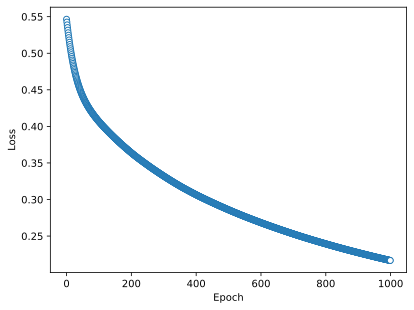

In [7]:
# create everything
ANNclassify, lossfun, optimizer = createANNmodel(.01)

# run it
losses, predictions, totalacc = trainTheModel(ANNclassify)

# report accuracy
print("Final accuracy: %g%%" %totalacc)

# show the losses
plt.plot(losses.detach(), "o", markerfacecolor = "w", linewidth = .1)
plt.xlabel("Epoch"), plt.ylabel("Loss")
plt.show()

In [12]:
# the set of learning rates to test
learningrates = np.linspace(.001, .1, 40)

# initialize results output
accByLR = []
allLosses = np.zeros((len(learningrates), numepochs))

# loop thru learning rates
for i, lr in enumerate(learningrates):

    # create and run the model
    ANNclassify, lossfun, optimizer = createANNmodel(lr)
    losses, predictions, totalacc = trainTheModel(ANNclassify)

    # store the results
    accByLR.append(totalacc)
    allLosses[i, :] = losses.detach()

C:\Users\Admin\AppData\Local\Temp\ipykernel_13296\3262775802.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  allLosses[i, :] = losses.detach()


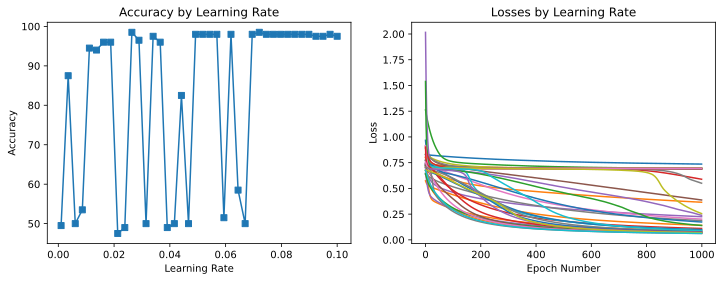

In [13]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(learningrates, accByLR, "s-")
ax[0].set_xlabel("Learning Rate")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy by Learning Rate")

ax[1].plot(allLosses.T)
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Loss")
ax[1].set_title("Losses by Learning Rate")
plt.show()

In [14]:
# proportion of runs where the model had atleast 70% accuracy
sum(torch.tensor(accByLR) > 70)/len(accByLR)

tensor(0.7000)

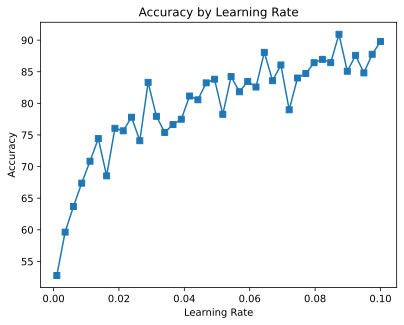

In [15]:
# run a "meta-experiment" by repeating the experiment N times
# (different random weight initializations each time)
# note: this cell takes ~7 mins

# number of times to iterate thru the experiment
numExps = 50

# matrix to store all results
accMeta = np.zeros((numExps, len(learningrates)))

# fewer epochs to reduce computation time
numepochs = 500

# now for the experiment
for expi in range(numExps):
    for i, lr in enumerate(learningrates):

        # create and run the model
        ANNclassify, lossfun, optimizer = createANNmodel(lr)
        losses, predictions, totalacc = trainTheModel(ANNclassify)
    
        # store the results
        accMeta[expi, i] = totalacc

# now plot the results, averaged over experiments
plt.plot(learningrates, np.mean(accMeta, axis = 0), "s-")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy by Learning Rate")
plt.show()